# Laboratory Task 7

**Exploring Hyperparameters (Activation Functions and Optimizers)**


🎯 Objective

In this lab, you will explore how different activation functions and optimizers affect the performance of a deep learning model. You will apply these hyperparameters to a custom image dataset of your choice and analyze how each configuration influences model training and accuracy.

**Import Libraries**

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Loading and exploring the data**

In [5]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
devbatrax_fracture_detection_using_x_ray_images_path = kagglehub.dataset_download('devbatrax/fracture-detection-using-x-ray-images')

print('Data source import complete.')

100%|██████████| 172M/172M [00:00<00:00, 230MB/s]

Extracting files...


Data source import complete.


In [7]:
# List the contents of the 'data' directory to find the correct path
data_dir = os.path.join(devbatrax_fracture_detection_using_x_ray_images_path, 'data')
print(os.listdir(data_dir))

['val', 'train']


In [8]:
# List the contents of the extracted dataset directory to find the correct path
print(os.listdir(devbatrax_fracture_detection_using_x_ray_images_path))

['data']


In [9]:
# Define the base path to the extracted dataset
base_dir = os.path.join(devbatrax_fracture_detection_using_x_ray_images_path, 'data')

# Create lists to store image paths and labels
image_paths = []
labels = []

# Define the class names
class_names = ['not fractured', 'fractured']

# Define the train and validation directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Iterate through the train and validation directories
for data_type_dir in [train_dir, val_dir]:
    # Iterate through the class subdirectories
    for class_name in class_names:
        class_dir = os.path.join(data_type_dir, class_name)
        # Iterate through the image files in each class directory
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image_paths.append(img_path)
            labels.append(class_name)

# Create a pandas DataFrame
data = pd.DataFrame({'path': image_paths, 'class': labels})

# Display the first few rows of the DataFrame
display(data.head())

# Display the class distribution
display(data['class'].value_counts())

,path,class
0,/root/.cache/kagglehub/datasets/devbatrax/frac...,not fractured
1,/root/.cache/kagglehub/datasets/devbatrax/frac...,not fractured
2,/root/.cache/kagglehub/datasets/devbatrax/frac...,not fractured
3,/root/.cache/kagglehub/datasets/devbatrax/frac...,not fractured
4,/root/.cache/kagglehub/datasets/devbatrax/frac...,not fractured


,count
class,
fractured,4840
not fractured,4623


In [11]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['class'])

# Display the shape of the training and validation DataFrames
print("Training data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)

# Define image dimensions
img_height = 128
img_width = 128
batch_size = 32

# Create ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create ImageDataGenerator for validation data (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

# Display the class indices
print("Class indices:", train_generator.class_indices)

Training data shape: (7570, 2)
Validation data shape: (1893, 2)
Found 7570 validated image filenames belonging to 2 classes.
Found 1893 validated image filenames belonging to 2 classes.
Class indices: {'fractured': 0, 'not fractured': 1}


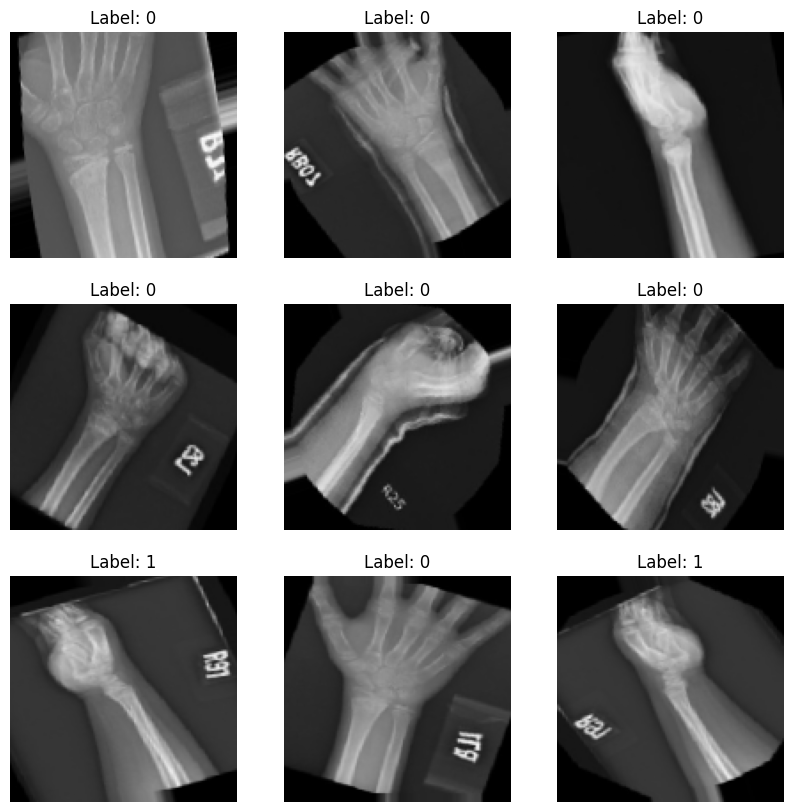

In [12]:
# Get a batch of images and labels from the training generator
images, labels = next(train_generator)

# Display the first few images from the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis("off")
plt.show()

**Define the base cnn model architecture**

In [13]:
def build_cnn_model(activation_func='relu', optimizer='adam'):
    """
    Builds a simple CNN model for image classification with flexible activation
    functions and optimizers.

    Args:
        activation_func (str): The activation function to use in hidden layers.
        optimizer (str): The optimizer to use for compiling the model.

    Returns:
        tensorflow.keras.models.Sequential: The built CNN model.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation=activation_func, input_shape=(img_height, img_width, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation=activation_func),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation=activation_func),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

**Set up experiment combinations**

In [14]:
experiments = [
    {'activation': 'relu', 'optimizer': 'adam'},
    {'activation': 'tanh', 'optimizer': 'sgd'},
    {'activation': 'leakyrelu', 'optimizer': 'rmsprop'},
    {'activation': 'elu', 'optimizer': 'adagrad'}
]

print(experiments)

[{'activation': 'relu', 'optimizer': 'adam'}, {'activation': 'tanh', 'optimizer': 'sgd'}, {'activation': 'leakyrelu', 'optimizer': 'rmsprop'}, {'activation': 'elu', 'optimizer': 'adagrad'}]


**Iterate through experiments**

In [15]:
for experiment in experiments:
    activation_func = experiment['activation']
    optimizer = experiment['optimizer']
    print(f"Running experiment with Activation: {activation_func}, Optimizer: {optimizer}")

Running experiment with Activation: relu, Optimizer: adam
Running experiment with Activation: tanh, Optimizer: sgd
Running experiment with Activation: leakyrelu, Optimizer: rmsprop
Running experiment with Activation: elu, Optimizer: adagrad


**Build and compile the model**

In [17]:
from tensorflow.keras.layers import LeakyReLU

def build_cnn_model(activation_func='relu', optimizer='adam'):
    """
    Builds a simple CNN model for image classification with flexible activation
    functions and optimizers.

    Args:
        activation_func (str): The activation function to use in hidden layers.
        optimizer (str): The optimizer to use for compiling the model.

    Returns:
        tensorflow.keras.models.Sequential: The built CNN model.
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(img_height, img_width, 3)))
    if activation_func == 'leakyrelu':
        model.add(LeakyReLU(negative_slope=0.01))
    else:
        model.add(tf.keras.layers.Activation(activation_func))

    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3)))
    if activation_func == 'leakyrelu':
        model.add(LeakyReLU(negative_slope=0.01))
    else:
        model.add(tf.keras.layers.Activation(activation_func))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128))
    if activation_func == 'leakyrelu':
        model.add(LeakyReLU(negative_slope=0.01))
    else:
        model.add(tf.keras.layers.Activation(activation_func))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

for experiment in experiments:
    activation_func = experiment['activation']
    optimizer = experiment['optimizer']
    print(f"Running experiment with Activation: {activation_func}, Optimizer: {optimizer}")

    # Build the model
    model = build_cnn_model(activation_func=activation_func, optimizer=optimizer)

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    print(f"Model for Activation: {activation_func}, Optimizer: {optimizer} built and compiled.")

Running experiment with Activation: relu, Optimizer: adam
Model for Activation: relu, Optimizer: adam built and compiled.
Running experiment with Activation: tanh, Optimizer: sgd
Model for Activation: tanh, Optimizer: sgd built and compiled.
Running experiment with Activation: leakyrelu, Optimizer: rmsprop


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model for Activation: leakyrelu, Optimizer: rmsprop built and compiled.
Running experiment with Activation: elu, Optimizer: adagrad
Model for Activation: elu, Optimizer: adagrad built and compiled.


**Train the model**

In [18]:
results = {}

for experiment in experiments:
    activation_func = experiment['activation']
    optimizer = experiment['optimizer']
    print(f"\nRunning experiment with Activation: {activation_func}, Optimizer: {optimizer}")

    # Build the model
    model = build_cnn_model(activation_func=activation_func, optimizer=optimizer)

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    print(f"Model for Activation: {activation_func}, Optimizer: {optimizer} built and compiled.")

    # Train the model
    epochs = 10
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator
    )
    print(f"Model training for Activation: {activation_func}, Optimizer: {optimizer} completed.")

    # Evaluate the model
    loss, accuracy = model.evaluate(val_generator)
    print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

    # Store results
    results[f"{activation_func}_{optimizer}"] = {
        'history': history.history,
        'validation_loss': loss,
        'validation_accuracy': accuracy
    }

print("\nAll experiments completed.")


Running experiment with Activation: relu, Optimizer: adam
Model for Activation: relu, Optimizer: adam built and compiled.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 46s 172ms/step - accuracy: 0.5534 - loss: 0.6935 - val_accuracy: 0.6609 - val_loss: 0.6134
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 160ms/step - accuracy: 0.6288 - loss: 0.6226 - val_accuracy: 0.6830 - val_loss: 0.5808
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 159ms/step - accuracy: 0.6901 - loss: 0.5747 - val_accuracy: 0.7993 - val_loss: 0.4565
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 156ms/step - accuracy: 0.7547 - loss: 0.4939 - val_accuracy: 0.8426 - val_loss: 0.3913
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 155ms/step - accuracy: 0.7800 - loss: 0.4487 - val_accuracy: 0.8780 - val_loss: 0.3180
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 155ms/step - accuracy: 0.7989 - loss: 0.4147 - val_accuracy: 0.8790 - val_loss: 0.2971
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 156ms/step - accuracy: 0.8096 - loss: 0.3888 - val_accuracy: 0.8991 - val_loss: 0.2517
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 155ms/step - accuracy: 0.8457 - loss: 0

**Summarize Results**

In [19]:
print("\n--- Experiment Summary ---")
for exp_name, metrics in results.items():
    print(f"Experiment: {exp_name}")
    print(f"  Validation Accuracy: {metrics['validation_accuracy']:.4f}")
    print(f"  Validation Loss: {metrics['validation_loss']:.4f}")



--- Experiment Summary ---
Experiment: relu_adam
  Validation Accuracy: 0.8695
  Validation Loss: 0.2853
Experiment: tanh_sgd
  Validation Accuracy: 0.6223
  Validation Loss: 0.6171
Experiment: leakyrelu_rmsprop
  Validation Accuracy: 0.9255
  Validation Loss: 0.2128
Experiment: elu_adagrad
  Validation Accuracy: 0.6212
  Validation Loss: 0.6280


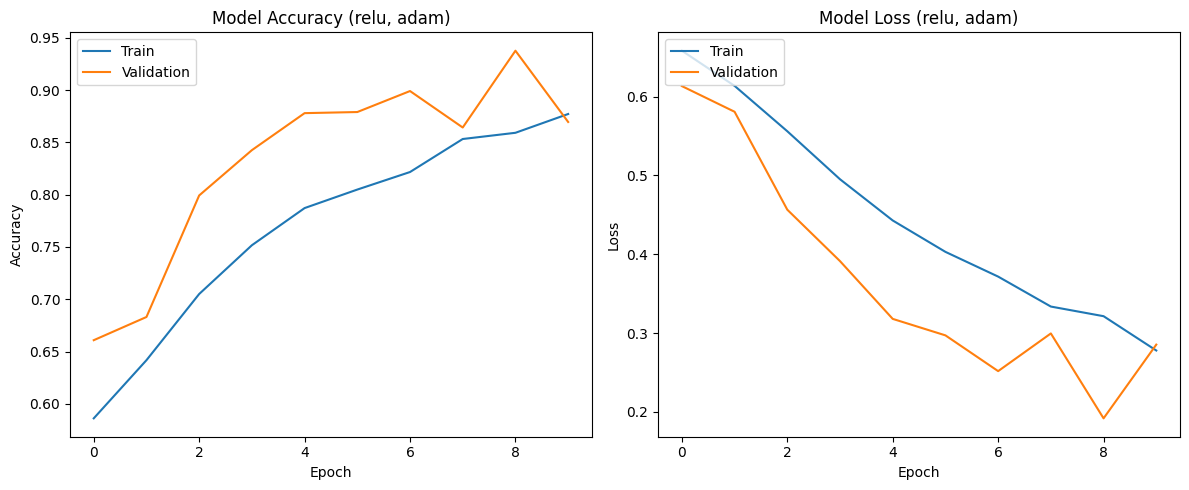

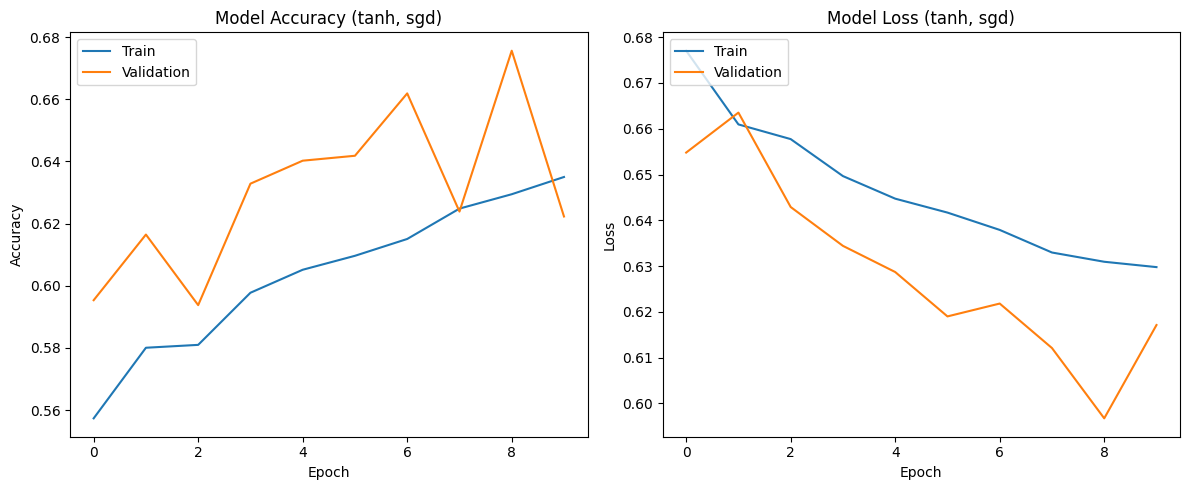

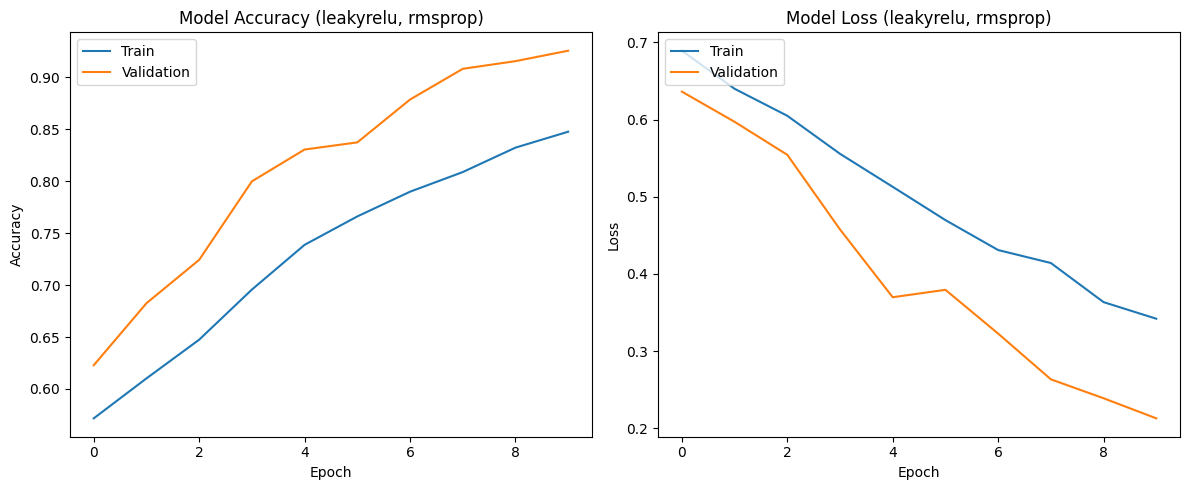

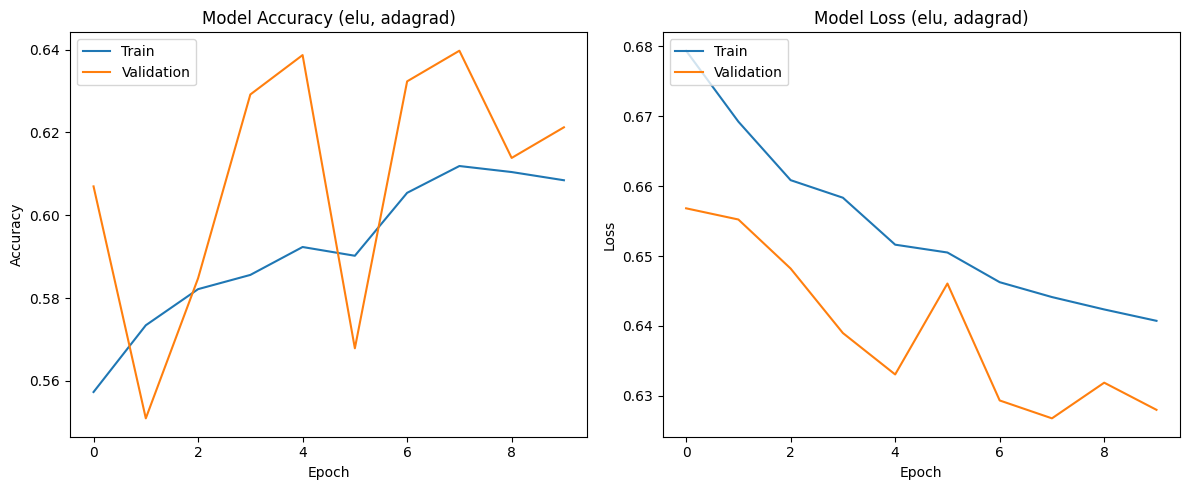

In [20]:
import matplotlib.pyplot as plt

for exp_name, metrics in results.items():
    history = metrics['history']
    activation_func = exp_name.split('_')[0]
    optimizer = exp_name.split('_')[1]

    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title(f'Model Accuracy ({activation_func}, {optimizer})')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(f'Model Loss ({activation_func}, {optimizer})')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

**Analysis and Comparison of Results**

Among the four experiments, **LeakyReLU with RMSprop** achieved the highest validation accuracy (**0.9255**) and lowest validation loss (**0.2128**), indicating the best model performance and generalization. The **ReLU with Adam** combination followed with a strong accuracy (**0.8695**) and moderate loss (**0.2853**). In contrast, **Tanh with SGD** and **ELU with Adagrad** yielded much lower accuracies (**≈0.62**) and higher losses (**>0.61**), showing slower learning and weaker convergence.

| Experiment        | Activation | Optimizer | Val Accuracy | Val Loss   | Remarks                           |
| ----------------- | ---------- | --------- | ------------ | ---------- | --------------------------------- |
| relu_adam         | ReLU       | Adam      | 0.8695       | 0.2853     | Fast convergence, good accuracy   |
| tanh_sgd          | Tanh       | SGD       | 0.6223       | 0.6171     | Slow learning, vanishing gradient |
| leakyrelu_rmsprop | LeakyReLU  | RMSprop   | **0.9255**   | **0.2128** | Best overall performance          |
| elu_adagrad       | ELU        | Adagrad   | 0.6212       | 0.6280     | Poor generalization               |

**Explanation of Performance Differences**


1. **Influence of Activation Functions**

- **ReLU (Rectified Linear Unit)** accelerates training by reducing vanishing gradients but may cause “dead neurons” when inputs are negative.

- **LeakyReLU** mitigates this by allowing small gradients for negative inputs, maintaining neuron activity throughout training—this likely contributed to its top performance.

- **ELU (Exponential Linear Unit)** can improve learning through smoother negative outputs but may saturate when paired with suboptimal optimizers like Adagrad.

- **Tanh** outputs in the range [-1, 1], which can cause vanishing gradients in deep networks, slowing convergence and limiting accuracy.


Reference:
Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press, Chapter 9.

2. **Impact of Optimizers**

- Adam combines momentum and adaptive learning rates, enabling stable and efficient convergence.

- RMSprop adapts learning rates for each parameter and handles non-stationary objectives well, which suits CNN training.

- SGD can converge slowly without momentum or learning rate scheduling.

- Adagrad adapts learning rates aggressively but can decay them too quickly, leading to underfitting.



Reference:
Kingma, D. P., & Ba, J. (2015). Adam: A Method for Stochastic Optimization. ICLR.

Hinton, G., Srivastava, N., & Swersky, K. (2012). Lecture 6: RMSProp.

The **LeakyReLU** + **RMSprop** combination achieved the best trade-off between accuracy and generalization, showing fast, stable convergence with minimal overfitting. It effectively balanced gradient flow and adaptive learning, leading to consistent performance across validation data.